## Economic activity in KCMO
Workplace Area Characteristics

In [1]:
# import packages for data manipulation
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd

# packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for interactivity
from ipywidgets import *
%matplotlib notebook

# set Seaborn context/style
sns.set_context(context='notebook')
sns.set_style('darkgrid')


In [2]:
import ipywidgets as iw
iw.__version__

'7.1.2'

In [3]:
# database connection
DB = 'datadb'
USER = 'postgres'
HOST = 'localhost'
PORT = '5432'
PW = 'postgres'

DB_CONNECTION_STRING = 'postgresql://{username}:{password}@{host}:{port}/{database}'.format(
username=USER, password=PW, host=HOST, port=PORT, database=DB)

engine = create_engine(DB_CONNECTION_STRING)

In [4]:
# function to get data - cbsafp = '28140' is KCMO metro area
def getWAC(seg='s000', jt='jt01', years=xrange(2002,2016), cbsafp = '28140'):
    # to pull data from database
    DFs = []
    # get data
    for year in years:
        qry = """
        SELECT *, left(w_geocode, 5) countyfp, {YR} AS year 
        FROM lodes.mo_wac_{SEG}_{JT}_{YR}
        WHERE left(w_geocode, 5) 
        IN (SELECT geoid FROM tl_2016_us_county WHERE cbsafp = '{CBSA}')
        """.format(SEG=seg, JT=jt, YR=year, CBSA=cbsafp)
        df = pd.read_sql(qry, engine)
#         df.drop(columns='createdate', inplace=True)
#         df['year'] = year
        DFs.append(df)
    # combine DFs into single dataframe
    df = pd.concat(DFs)
    return(df)

In [5]:
df = getWAC(years=xrange(2006,2014))
df.year.value_counts()

2006    10502
2008    10267
2007    10240
2009    10225
2010    10110
2013     8587
2012     8494
2011     8137
Name: year, dtype: int64

added following CRS to database to align with KCMO standard, from http://spatialreference.org/ref/esri/102698/postgis/

> INSERT into spatial_ref_sys (srid, auth_name, auth_srid, proj4text, srtext) values ( 102698, 'esri', 102698, '+proj=tmerc +lat_0=36.16666666666666 +lon_0=-94.5 +k=0.9999411764705882 +x_0=850000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs ', 'PROJCS["NAD_1983_StatePlane_Missouri_West_FIPS_2403_Feet",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",2788708.333333333],PARAMETER["False_Northing",0],PARAMETER["Central_Meridian",-94.5],PARAMETER["Scale_Factor",0.9999411764705882],PARAMETER["Latitude_Of_Origin",36.16666666666666],UNIT["Foot_US",0.30480060960121924],AUTHORITY["EPSG","102698"]]');

In [6]:
# get counties for map

qry = """
SELECT geoid, name,
    ST_Transform(geom, 102698) geom 
FROM tl_2016_us_county 
WHERE cbsafp = '{CBSA}' AND statefp = '29'
""".format(CBSA='28140')

counties = gpd.read_postgis(qry, engine, geom_col='geom')
counties['coords'] = counties.geometry.apply(lambda x: x.representative_point().coords[0])

In [7]:
counties.head()

,geoid,name,geom,coords
0,29037,Cass,"(POLYGON ((2757711.046145708 944487.779166155,...","(2827582.76366, 902996.782006)"
1,29165,Platte,(POLYGON ((2672765.821989374 1160319.813960498...,"(2716459.28694, 1157245.93518)"
2,29177,Ray,(POLYGON ((2870211.913921144 1128467.049151529...,"(2934245.1651, 1152428.64077)"
3,29107,Lafayette,(POLYGON ((2899444.881616506 1033552.724563697...,"(2988208.77351, 1069649.14907)"
4,29025,Caldwell,(POLYGON ((2871479.595406072 1287479.497680248...,"(2934492.20179, 1271114.0081)"


In [8]:
q = """
SELECT column_name FROM information_schema.columns 
WHERE table_name = 'tl_2016_us_county';
"""
# pd.read_sql(q, engine)

In [9]:
def plot_cnty(yr, col='ce01'): 
    sns.set_style('whitegrid')
    f, ax = plt.subplots(1, figsize=(8,6))
    # get specified data summarized by county
    cnty_df = pd.merge(counties,
                    df[df['year']==yr].groupby('countyfp')[col].sum().reset_index(), 
                    left_on='geoid', right_on='countyfp')
    colmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, as_cmap=True)
    cnty_df.plot(col, ax=ax, legend=True, cmap=colmap) 
    
    for idx, row in cnty_df.iterrows():
        ax.annotate(row['name'], row['coords'],
                     horizontalalignment='left', size='medium', color='white', 
                     weight='semibold',
                   bbox=dict(boxstyle="round,pad=0.3", fc="grey", ec="k", lw=0.5))
    
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
    
    f.suptitle('{} in {} by county, KCMO'.format(col, yr))

interact(plot_cnty, yr = df['year'].unique())#, col = df.columns.tolist()[1:])
# plot_cnty(2006, 'ce01')

interactive(children=(Dropdown(description=u'yr', options=(2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013), value=2006), Text(value=u'ce01', description=u'col'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_cnty>

![county map example](lodes_example_county_map.png)

In [10]:
# get BlockGroups for map

qry = """
SELECT blockgroup,
    ST_Transform(geom, 102698) geom 
FROM tl_2016_29_blkgrp
WHERE left(blockgroup, 5) 
    IN (SELECT geoid
        FROM tl_2016_us_county 
        WHERE cbsafp =  '{CBSA}')
""".format(CBSA='28140')

blocks = gpd.read_postgis(qry, engine, geom_col='geom')
blocks['coords'] = blocks.geometry.apply(lambda x: x.representative_point().coords[0])

In [11]:
print(df.columns.tolist())

[u'w_geocode', u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate', u'countyfp', u'year']


In [12]:
# add blockgroup code to df
df['bg'] = df['w_geocode'].apply(lambda g: g[:12])

In [13]:
%matplotlib notebook
def plot_bg(yr, col): 
    sns.set_style('whitegrid')
    f, ax = plt.subplots(1, figsize=(12,8))
    # get specified data summarized by county
    block_df = pd.merge(blocks,
                    df[df['year']==yr].groupby('bg')[col].sum().reset_index(), 
                    left_on='blockgroup', right_on='bg')
    colmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, as_cmap=True)
    counties.plot(ax=ax, color='white', edgecolor='grey')
    block_df.plot(col, ax=ax, legend=True, cmap=colmap) 
    
    for idx, row in counties.iterrows():
        ax.annotate(row['name'], row['coords'],
                     horizontalalignment='left', size='medium', color='white', 
                     weight='semibold',
                   bbox=dict(boxstyle="round,pad=0.3", fc="grey", ec="k", lw=0.5))
    
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
    
    f.suptitle('{} in {} by Block Group, KCMO'.format(col, yr))

interact(plot_bg,yr=df['year'].unique(), col=df.columns.tolist()[1:])

interactive(children=(Dropdown(description=u'yr', options=(2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013), value=2006), Dropdown(description=u'col', options=(u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate', u'countyfp', u'year', 'bg'), value=u'c000'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_bg>

In [17]:
counties['rand_float'] = counties.apply(lambda x: pd.np.random.random(), axis=1)

In [18]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
geoid         9 non-null object
name          9 non-null object
geom          9 non-null object
coords        9 non-null object
rand_float    9 non-null float64
dtypes: float64(1), object(4)
memory usage: 432.0+ bytes


In [34]:
# create number of tick marks in legend and set location to display them
numpoints = 5
leg_ticks = pd.np.linspace(-1,1,numpoints)

# create labels based on number of tickmarks
leg_min = counties['rand_float'].min()
leg_max = counties['rand_float'].max()
leg_tick_labels = [str(round(x*100,1))+'%' for x in pd.np.linspace(leg_min,leg_max,numpoints)]

In [35]:
leg_tick_labels

['6.8%', '25.0%', '43.2%', '61.4%', '79.6%']

In [31]:
[-1] + [-.5, 0, .5] + [1]

[-1, -0.5, 0, 0.5, 1]

In [36]:
leg_kwds_dict = {'numpoints': numpoints, 'labels': leg_tick_labels}

In [38]:
gpd.__version__

u'0.3.0'

In [ ]:
gpd.GeoDataFrame.plot()

<IPython.core.display.Javascript object>


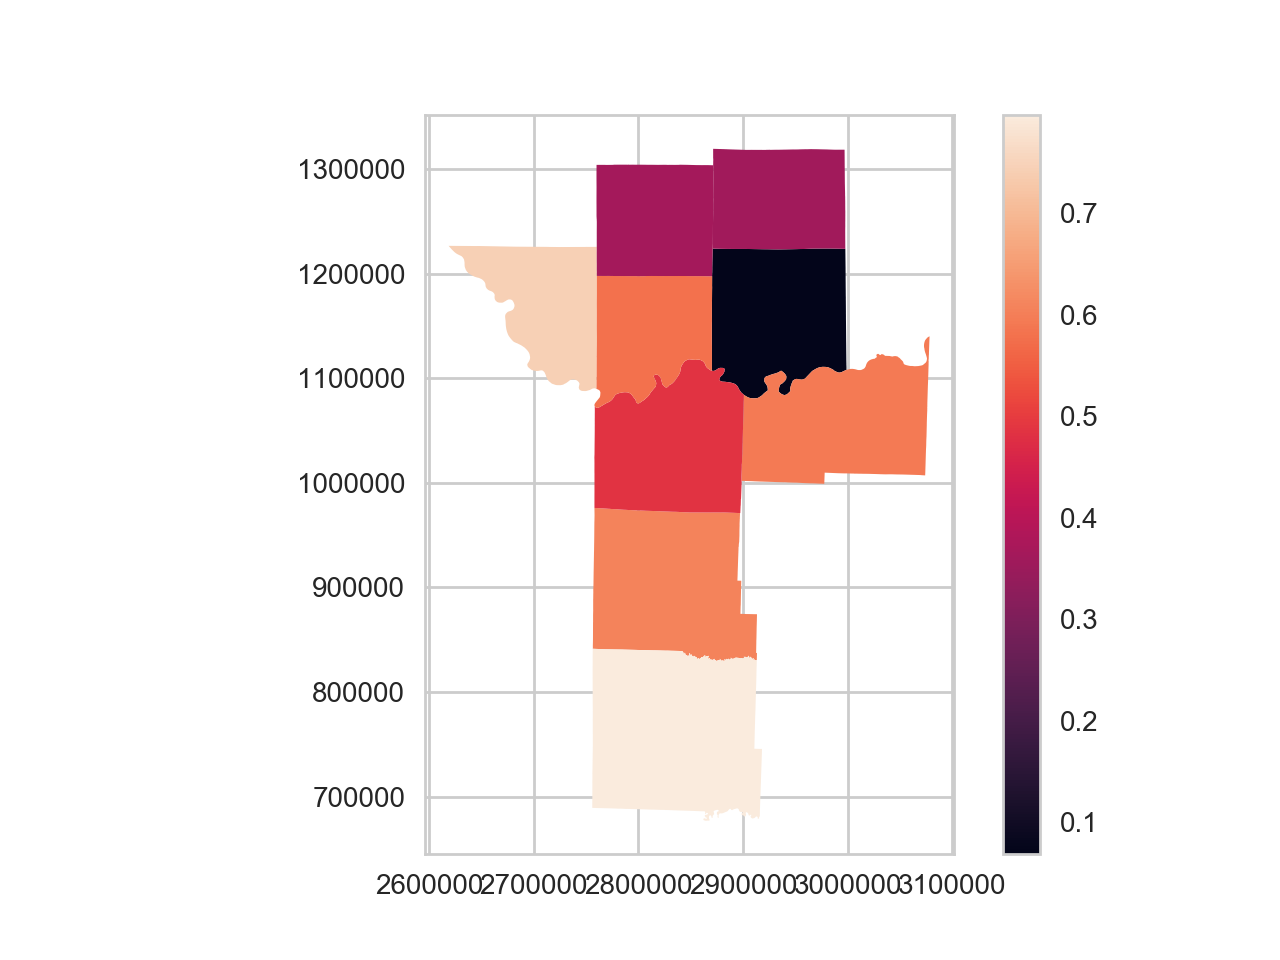

In [48]:
f, ax = plt.subplots(1, figsize=(6,6))
# ax = 
counties.plot('rand_float', legend=True, ax=ax)#, legend_kwds=leg_kwds_dict)
# ax.legend()
handles, labels = ax.get_legend_handles_labels() # does not return either handles or labels


In [49]:
len(handles)

0

In [16]:
# prep data for comparison of variables over time
dfpl = df.groupby('year')[df.columns.tolist()[1:-3]].sum().reset_index()
dfpl2 = pd.melt(dfpl, id_vars='year', value_vars=df.columns.tolist()[1:-3])

/Users/crh278/anaconda3/envs/ada-env/lib/python2.7/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/Users/crh278/anaconda3/envs/ada-env/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [17]:
# sns.pointplot('ce01', 'ca02', 'year', data=df, markers='o')#, linestyles='--', )

dfpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 52 columns):
year     8 non-null int64
c000     8 non-null int64
ca01     8 non-null int64
ca02     8 non-null int64
ca03     8 non-null int64
ce01     8 non-null int64
ce02     8 non-null int64
ce03     8 non-null int64
cns01    8 non-null int64
cns02    8 non-null int64
cns03    8 non-null int64
cns04    8 non-null int64
cns05    8 non-null int64
cns06    8 non-null int64
cns07    8 non-null int64
cns08    8 non-null int64
cns09    8 non-null int64
cns10    8 non-null int64
cns11    8 non-null int64
cns12    8 non-null int64
cns13    8 non-null int64
cns14    8 non-null int64
cns15    8 non-null int64
cns16    8 non-null int64
cns17    8 non-null int64
cns18    8 non-null int64
cns19    8 non-null int64
cns20    8 non-null int64
cr01     8 non-null int64
cr02     8 non-null int64
cr03     8 non-null int64
cr04     8 non-null int64
cr05     8 non-null int64
cr07     8 non-null int64
ct01     8 non-

<IPython.core.display.Javascript object>


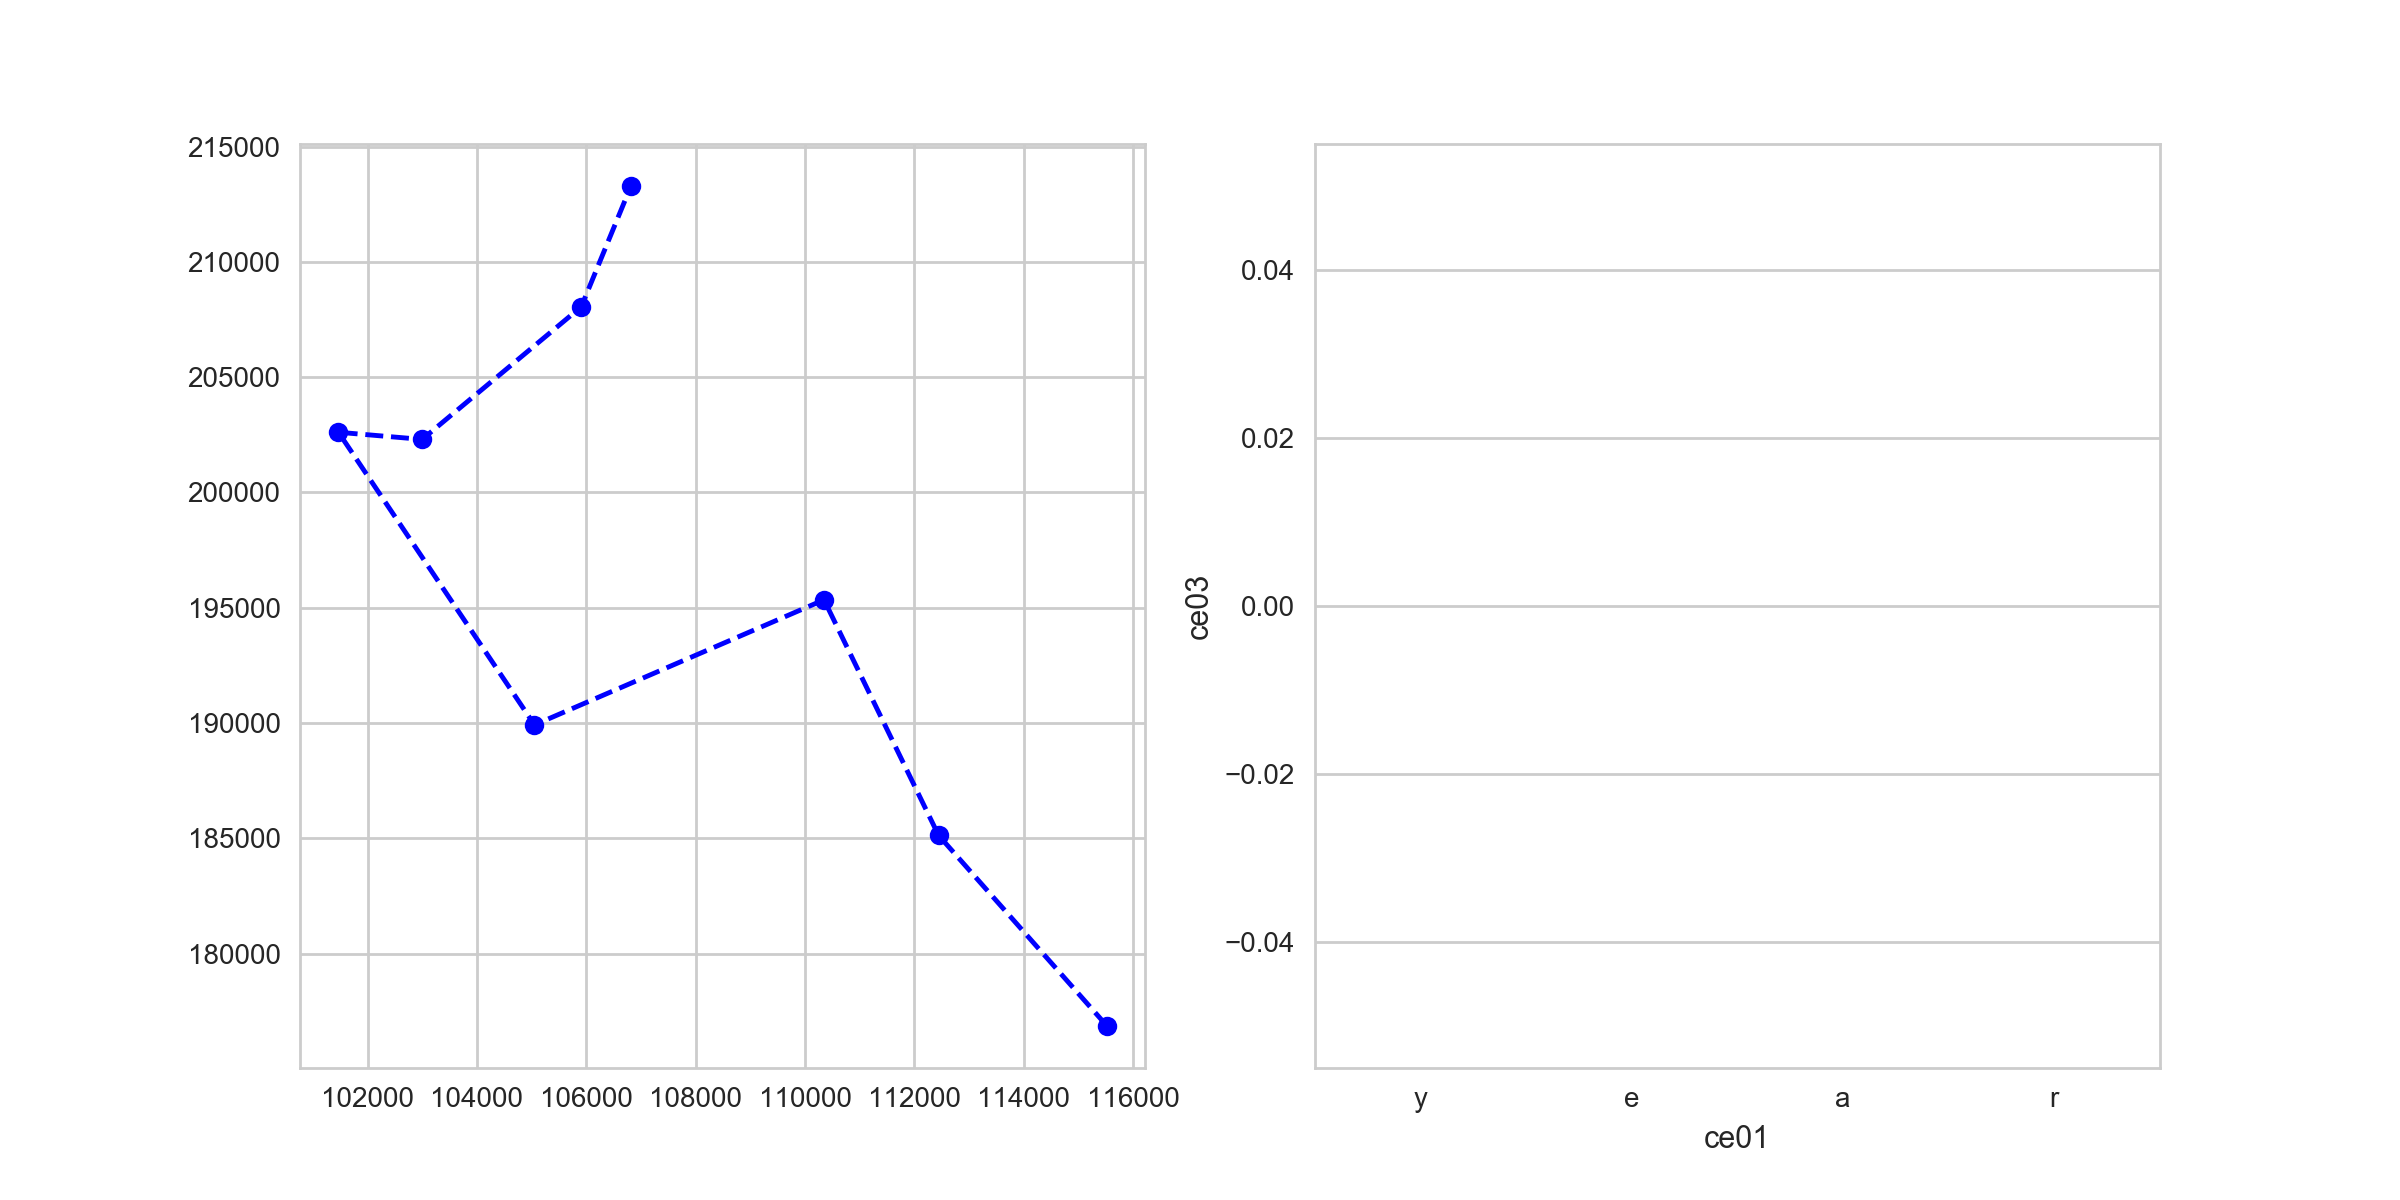

In [18]:
col1='ce01'
col2='ce03'

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(dfpl[col1], dfpl[col2], 'bo--')
sns.pointplot(x=col1, y=col2, data=dfpl, order='year', markers='o', linestyles='--', ax=ax2)

# for i, r in dfpl.iterrows():
# #     ax2.annotate(r['year'], (r[col1]+0.2, r[col2]+0.2),
# #                  horizontalalignment='left', size='medium', color='black', 
# #                  weight='semibold')
#     f.text(r['year'], r[col1]+0.2, r[col2]+0.2,
#                      horizontalalignment='left', size='medium', color='black', 
#                      weight='semibold')
#     g.map(plt.annotate, s=r['year'], xy=(r[col1]+0.2, r[col2]+0.2))

In [17]:
dfpl.loc[:,('year', 'ce01', 'ce03')]

,year,ce01,ce03
0,2006,115522,176863
1,2007,112442,185130
2,2008,110347,195344
3,2009,105053,189921
4,2010,101468,202611
5,2011,102998,202301
6,2012,105908,208052
7,2013,106817,213290


In [19]:
## compare two columns in two side by side graphs: bar chart over time and scatter plot of col1 v col2 over time
%matplotlib notebook
# @interact(compare_cols, col1=df.columns.tolist()[1:-2], col2=df.columns.tolist()[1:-2])
def compare_cols(col1, col2):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    f.suptitle('Comparing {} and {} over time'.format(col1, col2))

    sns.barplot('year', 'value', 'variable', data=dfpl2[dfpl2['variable'].isin([col2, col1])], ax=ax1)
    ax1.set_ylabel('Count')
#     ax1.set_title('{} and {}'.format(col1, col2))
#     ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    ax2.plot(dfpl[col1], dfpl[col2], 'bo--')
#     sns.pointplot(x=col1, y=col2, hue='year', data=dfpl2, markers='o', linestyles='--', ax=ax2)
    ax2.set_ylabel(col2)
    ax2.set_xlabel(col1)

    for i, r in dfpl.iterrows():
        ax2.annotate(r['year'], (r[col1]+0.2, r[col2]+0.2),
                     horizontalalignment='left', size='medium', color='black', 
                     weight='semibold')
#         f.text(r['year'], r[col1]+0.2, r[col2]+0.2,
#                      horizontalalignment='left', size='medium', color='black', 
#                      weight='semibold')
#         ax2.arrow(r[col1], r[col2], r[col1]+0.5, r[col2]+0.5, shape='full',
#                   lw=0, length_includes_head=True, head_width=.5)
    # return f? or plt?
#     return(f) # no, duplicates image - maybe because %matplotlib magic?

interact(compare_cols, col1=df.columns.tolist()[1:-2], col2=df.columns.tolist()[1:-2])

interactive(children=(Dropdown(description=u'col1', options=(u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate', u'countyfp'), value=u'c000'), Dropdown(description=u'col2', options=(u'c000', u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20', u'cr01', u'cr02', u'cr03', u'cr04', u'cr05', u'cr07', u'ct01', u'ct02', u'cd01', u'cd02', u'cd03', u'cd04', u'cs01', u'cs02', u'cfa01', u'cfa02', u'cfa03', u'cfa04', u'cfa05', u'cfs01', u'cfs02', u'cfs03', u'cfs04', u'cfs05', u'createdate', u'countyfp'), value=u'c000'), Output()), _dom_classes=('widget-interact',))

<function __main__.compare_cols>

![Column compare example](lodes_example_column_compare.png)

In [19]:
df_test = pd.DataFrame({'var1': [pd.np.random.random() for x in xrange(1000)],
                       'var2': [pd.np.random.random() for x in xrange(1000)]})

In [20]:
def df_plot(col):
    f, ax = plt.subplots()
    sns.distplot(df_test[col])
#     plt.show()
    
interact(df_plot, col=df_test.columns.tolist())

interactive(children=(Dropdown(description=u'col', options=('var1', 'var2'), value='var1'), Output()), _dom_classes=('widget-interact',))

<function __main__.df_plot>